In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#%pushd
#%cd ".."
import musictoys
from musictoys import audiofile
import musictoys.analysis
#%popd

In [2]:
# Configurations cannot occur in the same cell as the %matplotlib magic.
# All those configs just get ignored.
plt.style.use('bmh')
plt.rc('figure', figsize=(16,3))
plt.rc('image', aspect='auto', interpolation='bicubic')
def plotgram(matrix, cmap='gray'):
    plt.imshow(matrix.T, cmap=cmap)
    plt.gca().invert_yaxis()
    plt.show()

In [4]:
#filedata, filerate = musictoys.audiofile.read("audio_files/kronfeld-dreamatic.wav")
#filedata, filerate = musictoys.audiofile.read("audio_files/jfb-back_home.wav")
filedata, filerate = musictoys.audiofile.read("audio_files/liberty_chaps-get_up_get_down.wav")
samples, samplerate = musictoys.analysis.normalize(filedata, filerate)

In [5]:
frame_size = 1024
step_size = frame_size / 2
num_frames = int((len(samples) - frame_size + 1) / step_size)
graph_height = 256
gridx, gridy = np.mgrid[0:num_frames, 0:graph_height]

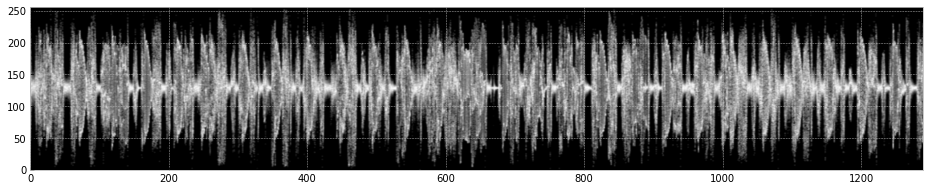

In [6]:
mag2d = np.zeros((num_frames, graph_height))
for i in range(num_frames):
    clip = samples[i*step_size:i*step_size+frame_size]
    hist, bin_edges = np.histogram(clip, bins=graph_height, range=(-1,1))
    mag2d[i] = hist / np.float(hist.max())
# normalize each frame's samples: divide by its max value
# take sqrt to represent power with brightness
power2d = np.sqrt(mag2d)
plotgram(power2d)

In [7]:
hann = np.hanning(frame_size)

spectrogram = []
for i in range(num_frames):
    clip = samples[i*step_size:i*step_size+frame_size]
    spectrogram.append(np.fft.rfft(clip * hann)[:frame_size/2])

spectrogram = np.array(spectrogram)
# take absolute value to get magnitude
spectrogram = (np.absolute(spectrogram) * 2.0) / np.sum(hann)
# square to get power
powerspectrogram = np.square(spectrogram)
# convert to decibels, clip noise floor
loudnessgram = (10 * np.log10(powerspectrogram)).clip(-120)
# compute the center frequency of each FFT bin
nyquist_freq = samplerate / 2.0
fft_bin_freq = np.arange(spectrogram.shape[1]) * nyquist_freq / float(spectrogram.shape[1])
half_nyquist = nyquist_freq / 2.0

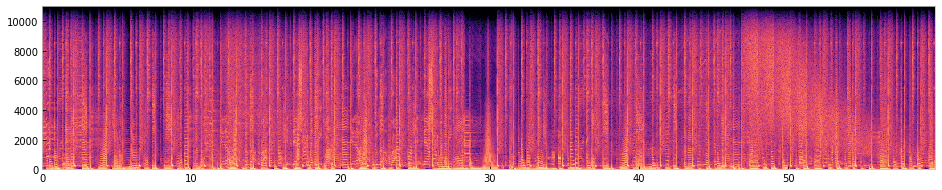

In [8]:
times = np.arange(0, spectrogram.shape[0], dtype=np.float) * frame_size / samplerate / 1
plt.pcolormesh(times, fft_bin_freq, loudnessgram.T, vmin=-120, vmax=0, cmap='magma')
plt.gca().set_xlim(0, times[-1])
plt.gca().set_ylim(0, fft_bin_freq[-1])
plt.show()

In [9]:
def spectral_centroid(spectrogram, samplerate):
    # the axes should be ordered [samples, bins]
    num_bins = spectrogram.shape[1]
    bin_idx = np.arange(num_bins, dtype=np.float)
    bin_center_freq = bin_idx * (samplerate / 2.0) / float(num_bins)
    magspec = np.abs(spectrogram)
    weighted_bins = bin_center_freq[np.newaxis,:] * magspec
    return np.sum(weighted_bins, axis=1) / np.sum(magspec, axis=1)

In [10]:
def spectral_spread(spectrogram, samplerate):
    centroid = spectral_centroid(spectrogram, samplerate)
    num_bins = spectrogram.shape[1]
    bin_idx = np.arange(num_bins, dtype=np.float)
    bin_center_freq = bin_idx * (samplerate / 2.0) / float(num_bins)
    variance = np.square(bin_center_freq[np.newaxis,:] - centroid[:,np.newaxis])
    magspec = np.abs(spectrogram)
    numerator = np.sum(variance * magspec, axis=1)
    denominator = np.sum(magspec, axis=1)
    return np.sqrt((numerator * 1.0) / denominator)

In [11]:
def spectral_crest(spectrogram):
    return spectrogram.max(axis=1) / spectrogram.sum(axis=1)

In [12]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1 + (freq/700.0))

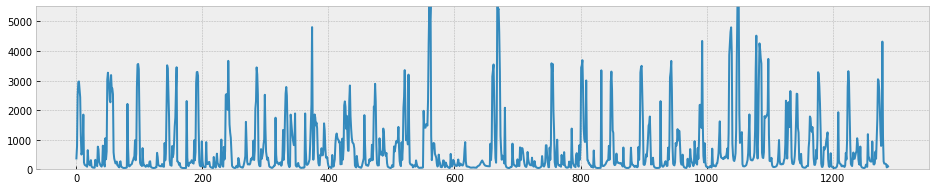

In [13]:
centroids = spectral_centroid(powerspectrogram, samplerate)
plt.plot(centroids)
plt.ylim((0, half_nyquist))
plt.show()

spread mean == 902.77, std == 784.18, min==14.44, max==3489.49


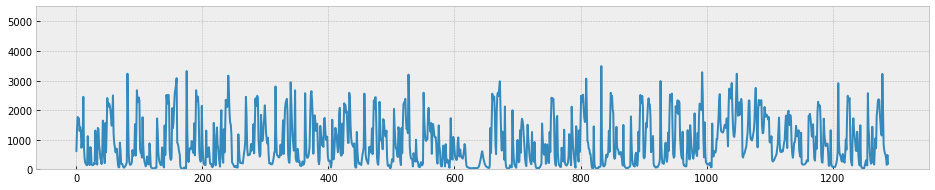

In [14]:
spreads = spectral_spread(powerspectrogram, samplerate)
print "spread mean == %.2f, std == %.2f, min==%.2f, max==%.2f" % (spreads.mean(), spreads.std(), spreads.min(), spreads.max())
plt.plot(spreads)
plt.ylim((0, half_nyquist))
plt.show()

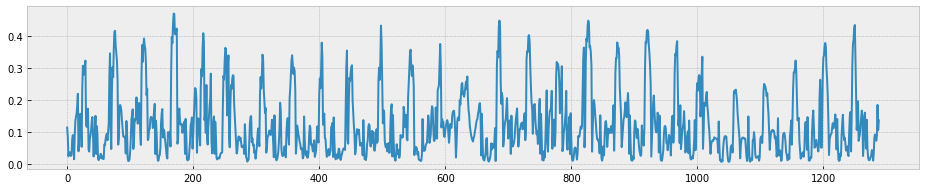

In [15]:
crests = spectral_crest(spectrogram)
plt.plot(crests)
plt.show()

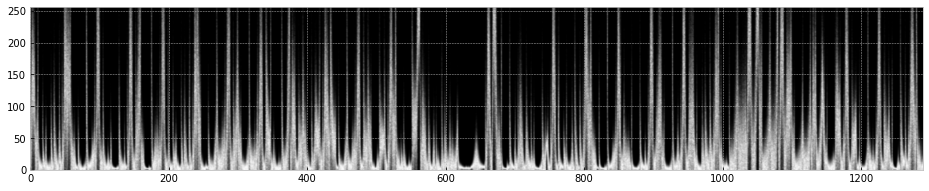

In [16]:
spectrum2d = np.zeros((num_frames, graph_height))
# generate a normal distribution representing centroid & spread
for i in range(num_frames):
    centroid = centroids[i]
    spread = spreads[i]
    distribution = centroid + spread * np.random.randn(10000)
    hist, bin_edges = np.histogram(distribution, bins=graph_height, range=(0,half_nyquist))
    spectrum2d[i] = hist
spectrum2d /= spectrum2d.max(axis=1)[gridx]
plotgram(spectrum2d)

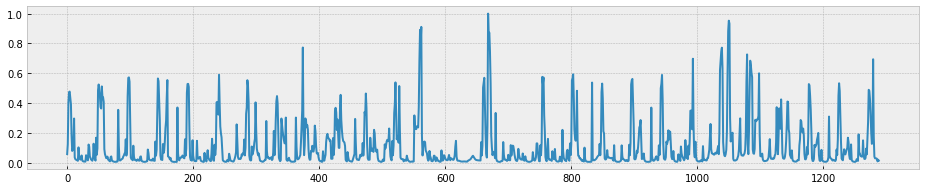

In [19]:
#hues = np.log10(1 + (centroids / 600.0)) ** np.e
hues = centroids / half_nyquist
hues /= hues.max()
plt.plot(hues)
plt.show()

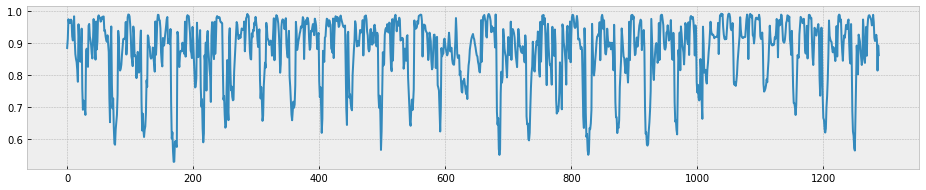

In [20]:
saturations = 1.0 - crests
plt.plot(saturations)
# yes! this is the one

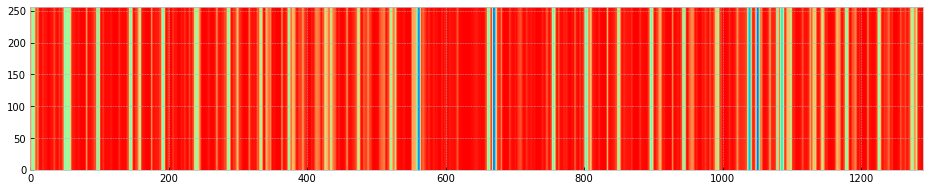

In [21]:
# generate corresponding hue and saturation matrices
hue2d = hues[gridx]
plotgram(hue2d, cmap='rainbow_r')

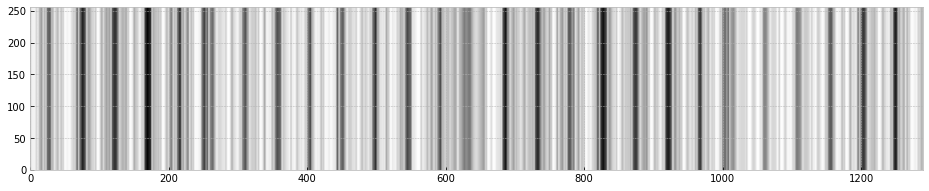

In [22]:
sat2d = saturations[gridx]
plotgram(sat2d)

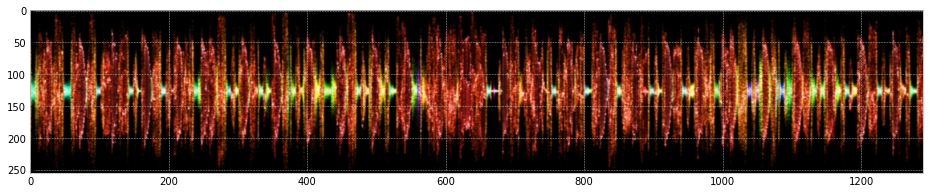

In [25]:
def hsl_to_rgb(h, s, l):
    shape = h.shape
    
    # all inputs and outputs range 0..1
    r = np.zeros(shape)
    g = np.zeros(shape)
    b = np.zeros(shape)
    
    # where the color is totally desaturated, use only luminance
    grey = (s==0)
    r[grey] = l[grey]
    g[grey] = l[grey]
    b[grey] = l[grey]
    
    # scale the saturation differently around medium luminance
    q = np.zeros(shape)
    low_luma = l < 0.5
    q[low_luma] = l[low_luma] * (1 + s[low_luma])
    hi_luma = l >= 0.5
    q[hi_luma] = l[hi_luma] + s[hi_luma] - l[hi_luma] * s[hi_luma]
    # the other hue factor is proportional
    p = 2 * l - q;
    
    def channel(t):
        # enforce limits
        t[t < 0] += 1.0
        t[t > 1] -= 1.0
        x = np.zeros(shape)
        tA = t < 1/6.
        x[tA] = p[tA] + (q[tA] - p[tA]) * 6 * t[tA] 
        tB = (t >= 1/6.) & (t < 1/2.)
        x[tB] = q[tB]
        tC = (t >= 1/2.) & (t < 2/3.)
        x[tC] = p[tC] + (q[tC] - p[tC]) * (2/3. - t[tC]) * 6
        tD = t >= 2/3.
        x[tD] = p[tD]
        return x

    chroma = (s != 0)
    r[chroma] = channel(h + 1./3.)[chroma]
    g[chroma] = channel(h)[chroma]
    b[chroma] = channel(h - 1./3.)[chroma]

    return r, g, b

r2d, g2d, b2d = hsl_to_rgb(hue2d, sat2d, mag2d)
image_rgb = np.stack((r2d.T, g2d.T, b2d.T), axis=2)
plt.imshow(image_rgb)
